In [1]:
!curl https://topcs.blob.core.windows.net/public/FlightData.csv -o flightdata.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1552k  100 1552k    0     0   735k      0  0:00:02  0:00:02 --:--:--  739k


In [2]:
import pandas as pd
import numpy as np
import math
from datetime import datetime

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [4]:
df = pd.read_csv('flightdata.csv') #import of the data
df.head() #five first rows

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [5]:
df.shape #shape of the dataframe - 11231 rows and 26 columns

(11231, 26)

In [6]:
df.isnull().values.any() #check if there are any missing values

True

In [7]:
df.isnull().sum() #check where missing values are

YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
UNIQUE_CARRIER             0
TAIL_NUM                   0
FL_NUM                     0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
DEST_AIRPORT_ID            0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                 107
DEP_DELAY                107
DEP_DEL15                107
CRS_ARR_TIME               0
ARR_TIME                 115
ARR_DELAY                188
ARR_DEL15                188
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME      188
DISTANCE                   0
Unnamed: 25            11231
dtype: int64

In [8]:
df = df.drop('Unnamed: 25', axis=1) #remove the 26th column - it is in file by mistake
df.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

In [9]:
df = df[["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15", "CANCELLED", "DIVERTED"]]
#select columns that are the most important for the model; avoid missing values
#"ARR_DEL15" means -> delay in arrival over 15 minutes [0- no, 1- yes]
#delay can be connected for example with season and the schedued departure time ["CRS_DEP_TIME"] (morning flights tend to be on time more often than afternoon or evening flights)

df.isnull().sum()

MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_DEP_TIME      0
ARR_DEL15       188
CANCELLED         0
DIVERTED          0
dtype: int64

In [10]:
df[df.isnull().values.any(axis=1)].head() 
#missing values appear in the "ARR_DEL15" coulmn when flights are cancelled or diverted

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15,CANCELLED,DIVERTED
177,1,9,6,MSP,SEA,701,NaN,0.0,1.0
179,1,10,7,MSP,DTW,1348,NaN,1.0,0.0
184,1,10,7,MSP,DTW,625,NaN,0.0,1.0
210,1,10,7,DTW,MSP,1200,NaN,1.0,0.0
478,1,22,5,SEA,JFK,2305,NaN,1.0,0.0


In [11]:
df = df[["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15"]] 
#we don't need "CANCELLED" and "DIVERTED" columns any more

df[df.isnull().values.any(axis=1)].head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,NaN
179,1,10,7,MSP,DTW,1348,NaN
184,1,10,7,MSP,DTW,625,NaN
210,1,10,7,DTW,MSP,1200,NaN
478,1,22,5,SEA,JFK,2305,NaN


In [12]:
df = df.fillna({'ARR_DEL15': 1})
#we can assume, that when flight is diverted or cancelled - it could be considered "late"
#so we can fill missing values with "1s"

df.iloc[177:185]
#iloc selection - in this case shows slice of rows

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,1.0
178,1,9,6,DTW,JFK,1527,0.0
179,1,10,7,MSP,DTW,1348,1.0
180,1,10,7,DTW,MSP,1540,0.0
181,1,10,7,JFK,ATL,1325,0.0
182,1,10,7,JFK,ATL,610,0.0
183,1,10,7,JFK,SEA,1615,0.0
184,1,10,7,MSP,DTW,625,1.0


In [13]:
df.isnull().sum()
#now we don't have any missing values

MONTH           0
DAY_OF_MONTH    0
DAY_OF_WEEK     0
ORIGIN          0
DEST            0
CRS_DEP_TIME    0
ARR_DEL15       0
dtype: int64

In [14]:
df["CRS_DEP_TIME"].nunique()
# nunique() function shows number of unique values in the column
# "CRS_DEP_TIME" column contains values from 0 to 2359 representing military times
# we had 551 unique values in this column - it is too many
# it could have a negative impact on accuracy in a machine-learning model

# by the way: count() function shows number of all non-null values; size function shows number of all values
# value_counts() function shows all unique values and their frequency in the column

551

In [16]:
# solution - binning (quantization)
# we should divide each number in this column by 100 and rounded down to the nearest integer
# 1030 would become 10, 1925 would become 19, and so on
# it will be left with a maximum of 24 discrete values in this column

for index, row in df.iterrows():
    df.loc[index, 'CRS_DEP_TIME'] = math.floor(row['CRS_DEP_TIME'] / 100)
    
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,0,0.0
1,1,1,5,DTW,MSP,0,0.0
2,1,1,5,ATL,SEA,0,0.0
3,1,1,5,SEA,MSP,0,0.0
4,1,1,5,SEA,DTW,0,0.0


In [17]:
# the dataset's ORIGIN and DEST columns contain airport codes that represent categorical machine-learning values.
# these columns need to be converted into discrete columns containing indicator variables ("dummy" variables).
# the ORIGIN column, which contains five airport codes, needs to be converted into five columns one per airport, 
# with each column containing 1s and 0s indicating whether a flight originated at the airport that the column represents. 
# the DEST column needs to be handled in a similar manner.

df = pd.get_dummies(df, columns=['ORIGIN', 'DEST'])

df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1,1,5,0,0.0,1,0,0,0,0,0,0,0,0,1
1,1,1,5,0,0.0,0,1,0,0,0,0,0,0,1,0
2,1,1,5,0,0.0,1,0,0,0,0,0,0,0,0,1
3,1,1,5,0,0.0,0,0,0,0,1,0,0,0,1,0
4,1,1,5,0,0.0,0,0,0,0,1,0,1,0,0,0


In [18]:
# to create a machine learning model, we need two datasets: one for training and one for testing. 
# if we have only one dataset, we can split it into two (80% train set - 20% test set). 
# we will also separate the DataFrame into feature columns and label columns.
# the former contains the columns used as input to the model 
# (for example, the flight's origin and destination and the scheduled departure time), 
# while the latter contains the column that the model will attempt to predict — in this case, the ARR_DEL15 column
# which indicates whether a flight will arrive on time.


train_x, test_x, train_y, test_y = train_test_split(df.drop('ARR_DEL15', axis=1), df['ARR_DEL15'], test_size=0.2, random_state=42)

In [19]:
train_x.shape

(8984, 14)

In [20]:
test_x.shape

(2247, 14)

In [21]:
train_y.shape

(8984,)

In [22]:
test_y.shape

(2247,)

In [23]:
#basic machine learning model

model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)

# the output shows the default parameters used in the classifier
# n_estimators - pecifies the number of trees in each decision-tree forest
# max_depth - specifies the maximum depth of the decision trees

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [24]:
#ACCURACY

predicted = model.predict(test_x)
model.score(test_x, test_y) # mean accuracy of the model; ok. 84% - flight will be on time

0.8366711170449488

In [25]:
#ROC AUC SCORE

probabilities = model.predict_proba(test_x)

In [26]:
roc_auc_score(test_y, probabilities[:, 1]) #ROC AUC score; ok. 67% - fligt will be on time

0.6546846350083707

In [27]:
#CONFUSION MATRIX

confusion_matrix(test_y, predicted)
# the first row - flights on time
# the first row, the first column - flight that were correctly predicted to be on time (according to model prediction)
# the first row, the second column - flight that were incorrectly predicted to be delayed (we wannt to have 0!)

# the second row - flights delayed
# the second row, the first column - flight that were incorrectly predicted to be on time (we want to have 0!)
# the second row, the second column - flight that were correctly predicted to be delayed

array([[1809,  127],
       [ 240,   71]])

In [28]:
#PRECISION

train_predictions = model.predict(train_x)
precision_score(train_y, train_predictions)

0.8047722342733189

In [29]:
#RECALL 

recall_score(train_y, train_predictions)

0.5926517571884984

Text(0, 0.5, 'True Positive Rate')

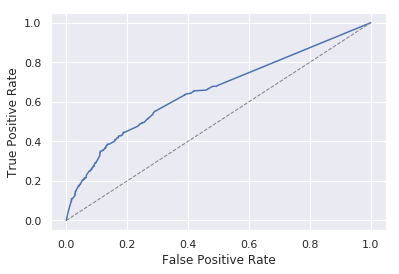

In [30]:
fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr) 
#the blue line - accuracy of the model

plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--') 
#the gray line - the graph represents a 50-50 chance of obtaining a correct answer

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [31]:
def predict_delay(departure_date_time, origin, destination):

    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()

    input = [{'MONTH': month,
              'DAY': day,
              'DAY_OF_WEEK': day_of_week,
              'CRS_DEP_TIME': hour,
              'ORIGIN_ATL': 1 if origin == 'ATL' else 0,
              'ORIGIN_DTW': 1 if origin == 'DTW' else 0,
              'ORIGIN_JFK': 1 if origin == 'JFK' else 0,
              'ORIGIN_MSP': 1 if origin == 'MSP' else 0,
              'ORIGIN_SEA': 1 if origin == 'SEA' else 0,
              'DEST_ATL': 1 if destination == 'ATL' else 0,
              'DEST_DTW': 1 if destination == 'DTW' else 0,
              'DEST_JFK': 1 if destination == 'JFK' else 0,
              'DEST_MSP': 1 if destination == 'MSP' else 0,
              'DEST_SEA': 1 if destination == 'SEA' else 0 }]

    return model.predict_proba(pd.DataFrame(input))[0][0]

In [32]:
predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL')
#the output shows that the likelihood of an on-time arrival is about 60%

0.5916666666666667

In [33]:
predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL')
#the output shows that the likelihood of an on-time arrival is about 83%

0.8333333333333334

In [34]:
predict_delay('2/10/2018 10:00:00', 'ATL', 'SEA')
#the output shows that the likelihood of an on-time arrival is about 92%

0.925

(0.0, 1.0)

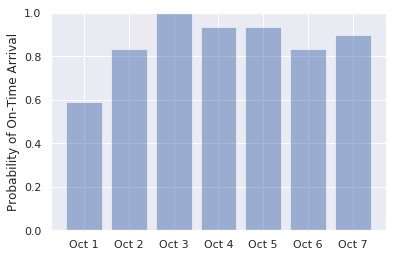

In [35]:
#code to plot the probability of on-time arrivals for an evening flight from JFK to ATL over a range of days:

labels = ('Oct 1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('3/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('4/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('5/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('6/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('7/10/2018 21:45:00', 'JFK', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))

(0.0, 1.0)

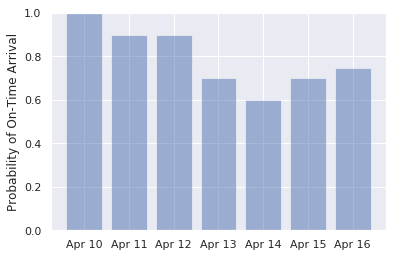

In [36]:
#code to plot the probability of on-time arrivals for flights around noon from JFK to MSP over a range of days:

labels = ('Apr 10', 'Apr 11', 'Apr 12', 'Apr 13', 'Apr 14', 'Apr 15', 'Apr 16')
values = (predict_delay('10/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('11/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('12/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('13/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('14/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('15/04/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('16/04/2018 13:00:00', 'JFK', 'MSP'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))

(0.0, 1.0)

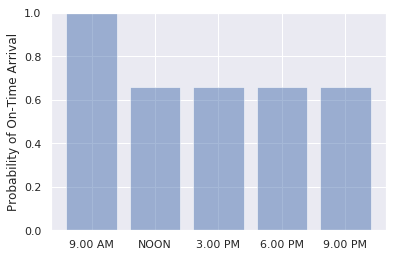

In [37]:
#code to plot the probability of on-time arrivals for flights from SEA to ATL over a range of day hours - 30.01.2018:

labels = ('9.00 AM', 'NOON', '3.00 PM', '6.00 PM', '9.00 PM')
values = (predict_delay('30/01/2018 09:00:00', 'SEA', 'ATL'),
          predict_delay('30/01/2018 12:00:00', 'SEA', 'ATL'),
          predict_delay('30/01/2018 15:00:00', 'SEA', 'ATL'),
          predict_delay('30/01/2018 18:00:00', 'SEA', 'ATL'),
          predict_delay('30/01/2018 21:00:00', 'SEA', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))